# Introduction

Consider the operator convex functions 
$$
    f_\alpha(x) = \frac{x^\alpha-\alpha(x-1) -1}{\alpha(\alpha-1)}
$$
for $\alpha\in[-1,2]$.
$f_0$ and $f_1$ are the pointwise limits
$$
f_0(x) = -\log(x) - x + 1,\qquad f_1(x) = x\log x - x + 1.
$$
These functions satisfy $f_\alpha(x) = xf_{1-\alpha}(1/x)$ and have integral representations
$$
f_\alpha(x) = \frac{\sin[(\alpha-1)\pi]}{\alpha(\alpha-1)\pi}\cdot (x-1)^2 \cdot\int_0^1\frac{t^{1-\alpha}(1-t)^\alpha d t}{1+t(x-1)}.
$$

The Julia module `AlphaDivergenceQuad` contains code to compute quadrature type approximations to $f_\alpha$
$$
r(x) = \sum_{i=1}^m\frac{u_i(x-1)^2}{1+t_i(x-1)}.
$$
Specifically, given a pair $(f_\alpha, f_\beta)$, we aim to find the quadrature rule with minimax error relative to $f_\beta$
$$
 \epsilon^{[m]}_{\alpha,\beta}:= \inf_{\substack{0\le t_1<\dots<t_m\le 1\\ u_i\ge0,\,i=1,\dots,m}} \left\{\,\sup_{x\in(0,\infty)}\,
\Bigl|\frac{f_\alpha(x) - \tilde{f}(x)}{f_\beta(x)}\Bigr| \; :\; r(x)=\sum_{i=1}^m \frac{u_i(x-1)^2}{1+t_i(x-1)}\right\}.
$$

If $\alpha\in(0,1)$, we this is possible for any $\beta\in[-1,2]$ (including $\beta=\alpha$, i.e. relative approximation).

If $\alpha\in(1,2)$, it is necessary to take $\beta>\alpha$. If $\alpha\in[-1,0]$, it is necessary to take $\beta<\alpha$.

## Using the function `minimax_quad`

Load the module:

In [1]:
include("alphadiv.jl")
using .AlphaDivergenceQuad

A solver that can handle linear programs is necessary for the differential correction iterations. In this example we choose Mosek.

In [2]:
using MosekTools
optimizer = Mosek.Optimizer

Optimizer (generic function with 2 methods)

The function which solves the above problem is `minimax_quad`. We specify $α, β$, and a range of values of $m$. The code will start from the lowest value of $m$ and work upwards, using information from previous computation as a warm start. For this reason, if you only want the best $m$-node quadrature rule, it can still be a good idea to supply the range `1:m`. Here we choose $\alpha=0$, $\beta=-1$, and $m=5$.

In [3]:
α = 0
β = -1
errors, quadrature_rules = minimax_quad(α, β, 1:5, optimizer);

[ Info: Computing best 1 node quadrature rule... 
[ Info: Finished! Error = 0.13310657032700735
[ Info: Computing best 2 node quadrature rule... 
[ Info: Finished! Error = 0.02579451993135451
[ Info: Computing best 3 node quadrature rule... 
[ Info: Finished! Error = 0.006947994270431357
[ Info: Computing best 4 node quadrature rule... 
[ Info: Finished! Error = 0.0022505049621763806
[ Info: Computing best 5 node quadrature rule... 
[ Info: Finished! Error = 0.0008230475899406731


The level of information printed can be controlled by setting the optional argument `verbosity` to 0 or 2 (default is 1).

We extract the best 5-node quadrature rule, 

In [4]:
μ = quadrature_rules[5]

Quadrature rule on [0, 1] with 5 nodes

and the associated error $\varepsilon_{0,-1}^{[5]}$.

In [5]:
ϵ = errors[end] 

0.0008230475899406731

The weights and nodes can be extracted from μ.

In [6]:
[weights(μ) nodes(μ)]

5×2 Matrix{Float64}:
 0.000355169  0.0103247
 0.0333748    0.131935
 0.252686     0.530159
 0.189691     0.897353
 0.0240525    0.993365

The quadrature based operator convex approximation to $f_0(x)=x-1-\log(x)$ is $r(x)=\sum_{i=1}^5\frac{u_i(x-1)^2}{1+t_i(x-1)}$.

In [7]:
r = x -> (x - 1)^2 * sum(u / (1 - t + t * x) for (t, u) in μ);

The approximation $r$ is visually indistinguishable from $f_0(x)$.

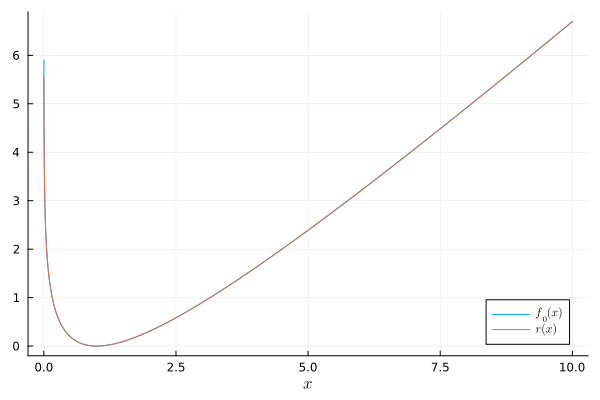

In [8]:
using Plots
X = 10 .^ (-3:0.001:1);
plot(X, X .- 1 .- log.(X), label="\$f_0(x)\$", xlabel="\$x\$")
plot!(X, r.(X), label="\$r(x)\$")

A more interesting plot is the weighted deviation
$$
\frac{f_0(x)-r(x)}{f_{-1}(x)}.
$$

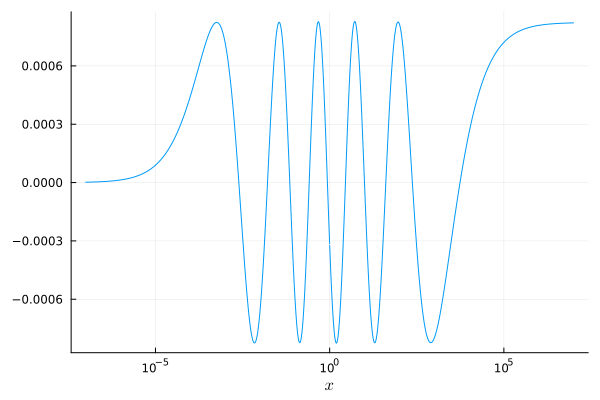

In [9]:
X = 10 .^ (-7:0.001:7);
plot(X, (X .- 1 .- log.(X) - r.(X)) ./ (X .-  1).^2 .* 2X, xaxis=:log, legend=false, xlabel="\$x\$")

### Visually monitoring equioscillation

One can provide a callback function to `minimax_quad` which will produce a plot like the above for each value of $m$ (number of nodes in the quadrature rule). 

In [10]:
function plotter(xk, errs)
    IJulia.clear_output(true)
    Plots.plot(xk, errs, xaxis=:log, xlabel="\$x\$", legend=false) |> IJulia.display
end

plotter (generic function with 1 method)

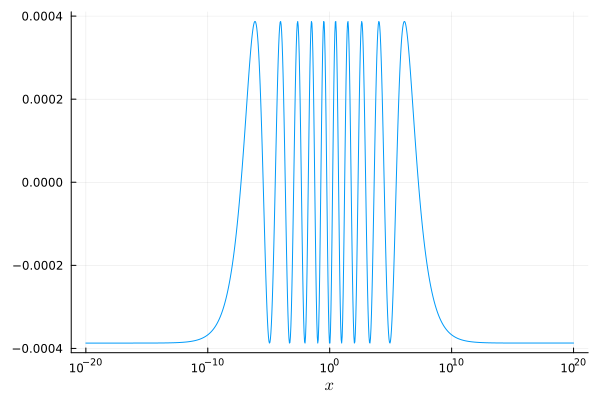

In [11]:
errors, quadrature_rules = minimax_quad(0.5, 0.5, 1:10, optimizer; callback=plotter, verbosity=0);

## Operator monotone lower bound for $\log x$

The function $\log(x)$ is operator monotone. Indeed it has a representation
$$
\log(x) = \int_0^1\frac{x-1}{1+t(x-1)}dt.
$$
In this section we will show how to obtain a quadrature rule which yields a lower bound
$$
0 \le \log(x) - \sum_{i=1}^m \frac{w_i(x-1)}{1+t_i(x-1)} \le \epsilon\cdot\frac{(x-1)^2}{x}.
$$

We will obtain such an approximation from the quadrature rule μ from earlier in this notebook.

The weights and nodes of μ satisfy $1-\sum_{i=1}^m\frac{u_i}{t_i}=\frac{\epsilon^{[m]}_{0,-1}}{2}$. 

In [12]:
1 - sum(u/t for (t,u) in μ), ϵ/2

(0.00041152379525366545, 0.00041152379497033653)

This is because the weighted deviation $\frac{f_0(x)-r(x)}{f_{-1}(x)}$ approaches $\epsilon^{[m]}_{0,-1}$ as   $x\to\infty$.

We can write
\begin{align*}
    \log(x) - (x-1) + \sum_{i=1}^m\frac{u_i(x-1)^2}{1+t_i(x-1)} &=
    \log(x) - (x-1) + (x-1)\sum_{i=1}^m\frac{u_i[1 + t_i(x-1) - 1]}{t_i[1+t_i(x-1)]}\\
    &=\log(x)  - \sum_{i=1}^m\frac{u_i(x-1)}{t_i[1+t_i(x-1)]} + \left[\sum_{i=1}^m\frac{u_i}{t_i}-1\right](x-1)\\
    &=\log(x)  - \sum_{i=1}^m\frac{u_i(x-1)}{t_i[1+t_i(x-1)]} - \frac{\epsilon^{[m]}_{0,-1}}{2}(x-1).
\end{align*}
Therefore,
\begin{equation*}
    0 \le \log(x)  - \sum_{i=1}^m\frac{u_i(x-1)}{t_i[1+t_i(x-1)]} - \frac{\epsilon^{[m]}_{0,-1}}{2}(x-1) + \frac{\epsilon^{[m]}_{0,-1}}{2}\cdot\frac{(x-1)^2}{x}\le \epsilon^{[m]}_{0,-1}\cdot\frac{(x-1)^2}{x}\qquad\forall\,x>0,
\end{equation*}
which simplifies to 
\begin{equation}\label{eq:opconvexapproxopt}
    0 \le \log(x)  - \sum_{i=1}^m\frac{u_i(x-1)}{t_i[1+t_i(x-1)]} - \frac{\epsilon^{[m]}_{0,-1}}{2}\cdot\frac{x-1}{x}\le \epsilon^{[m]}_{0,-1}\cdot\frac{(x-1)^2}{x}\qquad\forall\,x>0,
\end{equation}
i.e.
\begin{equation}
     0 \le \log(x)  - \sum_{i=1}^{m+1}\frac{w_i(x-1)}{1+t_i(x-1)} \le \epsilon^{[m]}_{0,-1}\cdot\frac{(x-1)^2}{x}\qquad\forall\,x>0,
\end{equation}
where $w_i:=u_i/t_i$ for $i\le m$, $t_{m+1}:=1$, and $w_{m+1}:=\epsilon^{[m]}_{0,-1}/2$.

In [13]:
ν = QuadratureRule([nodes(μ); 1], [weights(μ) ./ nodes(μ); ϵ/2])

Quadrature rule on [0, 1] with 6 nodes

In [14]:
r_lb = x -> (x-1) * sum(u / (1 - t + t * x) for (t, u) in ν);

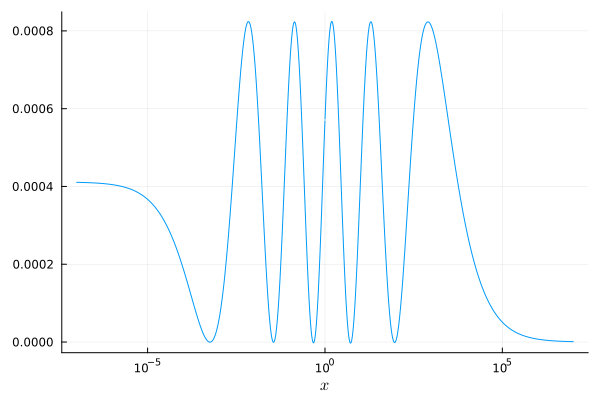

In [15]:
plot(X, (log.(X) - r_lb.(X)) ./ (X .-  1).^2 .* X, xaxis=:log, xlabel="\$x\$", legend=false)